# Bag of Words Meets Bags of Popcorn

### Use Google's Word2Vec for movie reviews
* https://www.kaggle.com/c/word2vec-nlp-tutorial
* Word2Vec을 통한 감정분석을 해보는 튜토리얼
* Google의 Word2Vec은 단어의 의미와 관계를 이해하는 데 도움
* 감정분석은 머신러닝(기계학습)에서 어려운 주제로 풍자, 애매모호한 말, 언어 유희로 표현을 하는데 이는 사람과 컴퓨터에게 모두 오해의 소지가 있다.
* [Bag-of-words model - Wikipedia](https://en.wikipedia.org/wiki/Bag-of-words_model)
* [자연 언어 처리 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%EC%9E%90%EC%97%B0_%EC%96%B8%EC%96%B4_%EC%B2%98%EB%A6%AC)
    * 자연 언어 처리(自然言語處理) 또는 자연어 처리(自然語處理)는 인간이 발화하는 언어 현상을 기계적으로 분석해서 컴퓨터가 이해할 수 있는 형태로 만드는 자연 언어 이해 혹은 그러한 형태를 다시 인간이 이해할 수 있는 언어로 표현하는 제반 기술을 의미한다. (출처 : 위키피디아)

### 평가 - ROC 커브(Receiver-Operating Characteristic curve)
* TPR과 FPR을 각각 x, y 축으로 놓은 그래프
* 민감도 TPR(True Positive Rate) 
    - 1인 케이스에 대해 1로 예측한 비율
    - 암환자를 진찰해서 암이라고 진단함
* 특이도 FPR(False Positive Rate)
    - 0인 케이스에 대해 1로 잘못 예측한 비율
    - 암환자가 아닌데 암이라고 진단함
    
* X, Y가 둘 다 [0, 1] 범위이고 (0, 0)에서 (1, 1)을 잇는 곡선이다.
* ROC 커브의 및 면적이 1에 가까울 수록(왼쪽 꼭지점에 다가갈수록) 좋은 성능

* 참고 : [New Sight :: Roc curve, AUR(AUCOC), 민감도, 특이도](http://newsight.tistory.com/53)
* [Receiver operating characteristic - Wikipedia](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

## 튜토리얼 개요
### 파트1 
* 초보자를 대상으로 기본 자연어 처리를 다룬다.

### 파트2, 3
* Word2Vec을 사용하여 모델을 학습시키는 방법과 감정분석에 단어 벡터를 사용하는 방법을 본다.

* 딥러닝은 빠르게 진화하는 분야이기 때문에 많은 양의 연구가 아직 출판되지 않았거나 학술 논문으로 존재한다. 
* 파트3는 레시피를 제공하지 않고 Word2Vec을 사용하는 몇 가지 방법을 실험해 본다.

* 긍정과 부정 리뷰가 섞여있는 100,000만개의 IMDB  감정분석 데이터 세트를 통해 목표를 달성해 본다.

# 파트 1

NLP는?
NLP(자연어처리)는 텍스트 문제에 접근하기 위한 기술집합이다.
이 튜토리얼에서는 IMDB 영화 리뷰를 로딩하고 정제하고 간단한 BOW(Bag of Word) 모델을 적용하여 리뷰가 추천인지 아닌지에 대한 정확도를 예측한다.


### 시작하기 전에
이 튜토리얼은 파이썬으로 되어 있으며, NLP에 익숙하다면 파트2 로 건너뛰어도 된다.

In [1]:
import pandas as pd

train = pd.read_csv('data/labeledTrainData.tsv', header=0, delimiter='\t', quoting=3)
train.shape

(25000, 3)

In [2]:
train.columns.values

array(['id', 'sentiment', 'review'], dtype=object)

In [3]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB


In [5]:
# html 태그가 섞여있기 때문에 이를 정제해줄 필요가 있음
train['review'][0][:700]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik'

### 데이터 정제
* 뷰티풀숩이 설치되지 않았다면 우선 설치해 준다.
```
pip install BeautifulSoup4
```

In [6]:
# 설치 및 버전확인
# !pip show BeautifulSoup4

In [7]:
from bs4 import BeautifulSoup

example1 = BeautifulSoup(train['review'][0], "html5lib")
print(train['review'][0][:700])
example1.get_text()[:700]

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik


'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

In [8]:
# 정규표현식을 사용해서 태그를 제거
import re
# 소문자와 대문자가 아닌 것은 공백으로 대체한다.
letters_only = re.sub('[^a-zA-Z]', ' ', example1.get_text())
letters_only[:700]

' With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

In [9]:
# 모두 소문자로 변환한다.
lower_case = letters_only.lower()
# 문자를 나눈다. => 토큰화
words = lower_case.split()

### Stopword Removal 불용어 제거

일반적으로 코퍼스에서 자주 나타나는 단어는 학습 모델로서 학습이나 예측 프로세스에 실제로 기여하지 않아 다른 텍스트와 구별하지 못한다. 예를들어 조사, 접미사, i, me, my, it, this, that, is, are 등 과 같은 단어는 빈번하게 등장하지만 실제 의미를 찾는데 큰 기여를 하지 않는다. Stopwords는 "to"또는 "the"와 같은 용어를 포함하므로 사전 처리 단계에서 제거하는 것이 좋다. NLTK에는 153 개의 영어 불용어가 미리 정의되어 있다. 17개의 언어에 대해 정의되어 있으며 한국어는 없다.


### NLTK 설치 
* http://corazzon.github.io/nltk_data_install 

In [10]:
import nltk
from nltk.corpus import stopwords
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your']

In [11]:
# stopwords 를 제거한 토큰들
words = [w for w in words if not w in stopwords.words('english')]
words[:10]

['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

### Porter Stemming and Lemmatizing
* "messages", "message", "messaging" 과 같이 복수형, 진행형 등의 문자를 같은 의미의 단어로 다룰 수 있도록 도와준다.

# 문자열 처리
*  위에서 간략하게 살펴본 내용을 바탕으로 문자열을 처리해 본다.

In [12]:
def review_to_words( raw_review ):
    # 1. HTML 제거
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. 영문자가 아닌 문자는 공백으로 변환
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. 소문자 변환
    words = letters_only.lower().split()
    # 4. 파이썬에서는 리스트보다 세트로 찾는게 훨씬 빠르다.
    # stopwords 를 세트로 변환한다.
    stops = set(stopwords.words('english'))
    # 5. Stopwords 불용어 제거
    meaningful_words = [w for w in words if not w in stops]
    # 6. 공백으로 구분된 문자열로 결합하여 결과를 반환
    return( ' '.join(meaningful_words) )

In [13]:
clean_review = review_to_words(train['review'][0])
clean_review

'stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directors hate workin

In [14]:
num_reviews = train['review'].size
# clean_train_reviews = []
# 캐글 튜토리얼에는 range가 xrange로 되어있지만 
# 여기에서는 python3를 사용하기 때문에 range를 사용했다.
# for i in range(0, num_reviews):
#     clean_train_reviews.append( review_to_words(train['review'][i]))

In [15]:
# 하지만 위 코드는 어느 정도 실행이 되고 있는지 알 수가 없어서
# 5000개 단위로 상태를 찍도록 개선했다.
# clean_train_reviews = []
# for i in range(0, num_reviews):
#     if (i + 1)%5000 == 0:
#         print('Review {} of {} '.format(i+1, num_reviews))
#     clean_train_reviews.append(review_to_words(train['review'][i]))
    
%time train['review_clean'] = train['review'].apply(review_to_words) 

CPU times: user 13.1 s, sys: 811 ms, total: 13.9 s
Wall time: 14.1 s


In [16]:
clean_train_reviews = train['review_clean']

In [17]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

def displayWordCloud(data = None, backgroundcolor = 'white', width=800, height=600 ):
    wordcloud = WordCloud(stopwords = STOPWORDS, 
                          background_color = backgroundcolor, 
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show() 

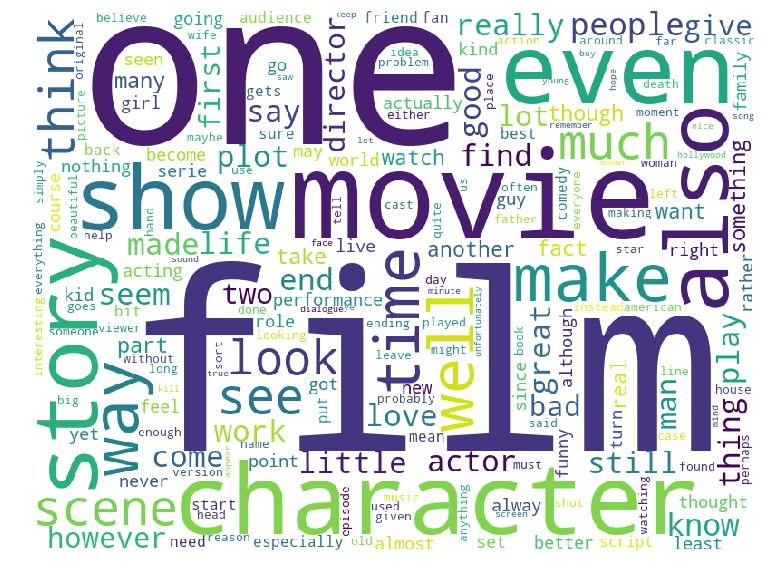

In [18]:
# 모든 단어에 대한 워드 클라우드를 그려본다.
displayWordCloud(' '.join(train['review_clean']))

In [19]:
# 단어 수
train['num_words'] = train['review_clean'].apply(lambda x: len(str(x).split()))
# 중복을 제거한 단어 수
train['num_uniq_words'] = train['review_clean'].apply(lambda x: len(set(str(x).split())))

In [20]:
x = train['review_clean'][0]
x = str(x).split()
print(len(x))
x[:10]

219


['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

Text(0.5,1,'리뷰별 단어 수, 고유한 단어 수 분포')

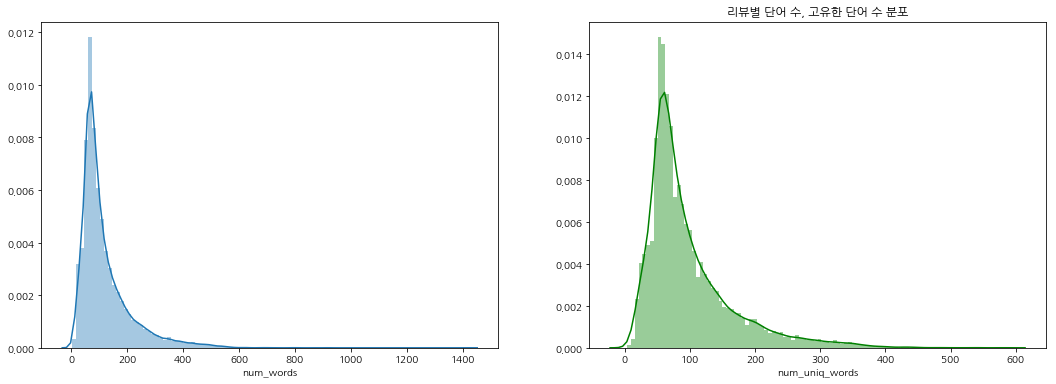

In [21]:
import seaborn as sns

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(18, 6)
sns.distplot(train['num_words'], bins=100, ax=axes[0])
sns.distplot(train['num_uniq_words'], bins=100, color='g', ax=axes[1])
plt.title('리뷰별 단어 수, 고유한 단어 수 분포')

### 사이킷런을 통해 피처 생성

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df=2,
                             max_features = 5000
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=2,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [23]:
train_data_features = vectorizer.fit_transform(clean_train_reviews)
train_data_features

<25000x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 1975015 stored elements in Compressed Sparse Row format>

In [24]:
train_data_features.shape

(25000, 5000)

In [25]:
vocab = vectorizer.get_feature_names()
vocab[:10]

['abandoned',
 'abc',
 'abilities',
 'ability',
 'able',
 'abraham',
 'absence',
 'absent',
 'absolute',
 'absolutely']

In [26]:
import numpy as np

dist = np.sum(train_data_features, axis=0)
for tag, count in zip(vocab, dist):
    print(count, tag)

[[187 125 108 ..., 740 518 147]] abandoned


In [27]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 100)
%time forest = forest.fit(train_data_features, train['sentiment'])

CPU times: user 58.5 s, sys: 693 ms, total: 59.2 s
Wall time: 1min 1s


In [28]:
test = pd.read_csv('data/testData.tsv', header=0, delimiter='\t', quoting=3)
test.shape

(25000, 2)

In [29]:
clean_test_reviews = []

def clean_review_text(review_data):
    num_reviews = len(review_data)
    for i in range(0, num_reviews):
        if (i + 1) % 5000 == 0:
            print('Review {} of {}'.format(i+1, num_reviews))
        clean_review = review_to_words(review_data[i])
        clean_test_reviews.append(clean_review)

%time clean_review_text(test['review'])

Review 5000 of 25000
Review 10000 of 25000
Review 15000 of 25000
Review 20000 of 25000
Review 25000 of 25000
CPU times: user 17.8 s, sys: 13.1 s, total: 30.9 s
Wall time: 32 s


In [30]:
clean_test_reviews[0]

'naturally film main themes mortality nostalgia loss innocence perhaps surprising rated highly older viewers younger ones however craftsmanship completeness film anyone enjoy pace steady constant characters full engaging relationships interactions natural showing need floods tears show emotion screams show fear shouting show dispute violence show anger naturally joyce short story lends film ready made structure perfect polished diamond small changes huston makes inclusion poem fit neatly truly masterpiece tact subtlety overwhelming beauty'

In [31]:
test_data_features = vectorizer.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()
test_data_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [32]:
result = forest.predict(test_data_features)

In [33]:
output = pd.DataFrame(data={'id':test['id'], 'sentiment':result})

In [34]:
output.to_csv('data/Bag_of_Words_model.csv', index=False, quoting=3)

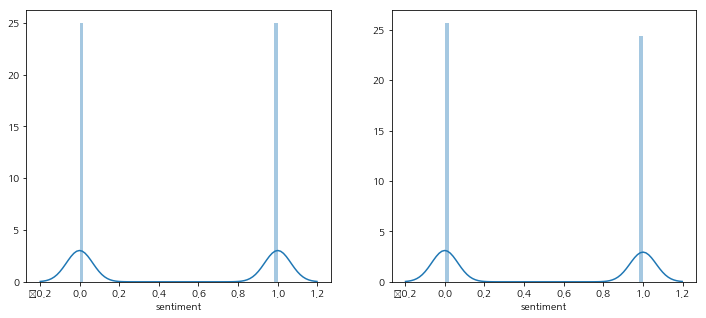

In [35]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(train['sentiment'], ax=axes[0], bins=50)
sns.distplot(output['sentiment'], ax=axes[1], bins=50)

첫 번째 제출을 할 준비가 되었다.
리뷰를 다르게 정리하거나 'Bag of Words' 표현을 위해 다른 수의 어휘 단어를 선택하거나 포터 스테밍 등을 시도해 볼 수 있다.
다른 데이터세트로 NLP를 시도해 보려면 로튼 토마토(Rotten Tomatoes)를 해보는 것도 좋다.
이미 준비가 되었다면, 딥러닝과 워드 벡터 페이지를 보는 것도 좋다.

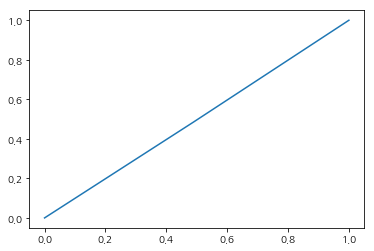

AUC: 0.49776


In [38]:
# 참고 : https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

y_true = train['sentiment']# true labels
y_probas = output['sentiment']# predicted results
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_probas, pos_label=0)

# Print ROC curve
plt.plot(fpr,tpr)
plt.show() 

# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)